# 데이터 추출 및 정제

### Docker BCK 파일 추출 코드

In [1]:
import re
import pandas as pd

# 파일 로드 (인코딩 "UTF-16 LE"로 지정)
with open("teslamate.bck", "r", encoding="UTF-16LE") as file:
    content_utf16 = file.read()

# 데이터 섹션의 시작 위치를 찾기
data_name_positions_utf16 = [match.start() for match in re.finditer(r"Data for Name: ", content_utf16)]
data_names_utf16 = [re.search(r"Data for Name: (\w+)", content_utf16[pos:]).group(1) for pos in data_name_positions_utf16]

# 각 데이터 섹션을 데이터프레임으로 변환
dataframes_utf16 = {}

for i in range(len(data_name_positions_utf16) - 1):
    data_section = content_utf16[data_name_positions_utf16[i]:data_name_positions_utf16[i+1]]

    # 데이터 제목 추출
    title_match = re.search(r"Data for Name: (\w+)", data_section)
    if not title_match:
        continue
    title = title_match.group(1)
    
    if title == "geofences":  # `geofences` 섹션 제외
        continue

    # 데이터 컬럼 추출
    columns_match = re.search(r"COPY public." + title + r" \(([^)]+)\) FROM stdin;", data_section)
    if not columns_match:
        continue
    columns = [col.strip() for col in columns_match.group(1).split(",")]

    # 데이터 내용 추출
    data_lines = data_section.split("\.\n")[0].split("\n")[4:]  # 첫 세 줄만 제외하고 데이터만 추출
    data = [line.split("\t") for line in data_lines if line and line != '--']  # 비어있지 않은 데이터만 추출

    # 데이터프레임 생성
    df = pd.DataFrame(data, columns=columns)
    dataframes_utf16[title] = df

# Excel로 내보내기
output_path = "teslamate_data_2.xlsx"
with pd.ExcelWriter(output_path) as writer:
    for title, df in dataframes_utf16.items():
        df.to_excel(writer, sheet_name=title, index=False)


### Positions 시트 전처리 코드

In [2]:
import pandas as pd
import numpy as np

# 1. 데이터 불러오기
positions_df = pd.read_excel('teslamate_data.xlsx', sheet_name='positions')

# 2. 데이터 전처리: "\N" 값을 NaN으로 변경
positions_df.replace("\\N", pd.NA, inplace=True)

# 3. 'date' 컬럼을 datetime 타입으로 변환
positions_df['date'] = pd.to_datetime(positions_df['date'])

# 4. 각 컬럼의 데이터 타입 최적화
cols_to_float = ['speed', 'ideal_battery_range_km', 'outside_temp', 'fan_status', 'driver_temp_setting',
                 'passenger_temp_setting', 'drive_id', 'inside_temp', 'est_battery_range_km', 
                 'rated_battery_range_km', 'usable_battery_level', 'tpms_pressure_fl', 
                 'tpms_pressure_fr', 'tpms_pressure_rl', 'tpms_pressure_rr']
bool_map = {'t': True, 'f': False}
cols_to_bool = ['is_climate_on', 'is_rear_defroster_on', 'is_front_defroster_on', 'battery_heater', 'battery_heater_on']

for col in cols_to_float:
    positions_df[col] = pd.to_numeric(positions_df[col], errors='coerce')
for col in cols_to_bool:
    positions_df[col] = positions_df[col].map(bool_map).astype('boolean')

positions_df.drop(['battery_heater_no_power', 'car_id'], axis=1, inplace=True)
positions_df['drive_id'] = positions_df['drive_id'].fillna(method='ffill').fillna(method='bfill')
positions_df_sorted = positions_df.sort_values(by='date').reset_index(drop=True)

# 5. 'elevation' 컬럼의 결측치 처리
elevation_null = positions_df_sorted['elevation'].isnull()
groups = ((elevation_null != elevation_null.shift()).cumsum())
groups_counts = elevation_null.groupby(groups).cumsum()
continuous_null_ranges = groups_counts[elevation_null].groupby(groups).agg(['idxmin', 'idxmax', 'count']).reset_index(drop=True)
continuous_null_ranges.columns = ['Start Index', 'End Index', 'Count']
for index, row in continuous_null_ranges.iterrows():
    start_idx = row['Start Index']
    end_idx = row['End Index']
    if start_idx > 0:
        prev_val = positions_df_sorted.loc[start_idx - 1, 'elevation']
    else:
        prev_val = np.nan
    if end_idx < len(positions_df_sorted) - 1:
        next_val = positions_df_sorted.loc[end_idx + 1, 'elevation']
    else:
        next_val = np.nan
    prev_val = float(prev_val) if pd.notnull(prev_val) else np.nan
    next_val = float(next_val) if pd.notnull(next_val) else np.nan
    mean_val = (prev_val + next_val) / 2
    positions_df_sorted.loc[start_idx:end_idx, 'elevation'] = mean_val

# 6. 'speed' 컬럼의 결측치 처리
positions_df_sorted['speed'].fillna(0, inplace=True)

# 7. 수치형 데이터 컬럼의 결측치 처리
numerical_cols = positions_df_sorted.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    positions_df_sorted[col] = positions_df_sorted[col].interpolate(method='linear', limit_direction='both')

# 8. 불리언 데이터 컬럼의 결측치 처리
boolean_cols = positions_df_sorted.select_dtypes(include=['boolean']).columns
for col in boolean_cols:
    positions_df_sorted[col].fillna(method='ffill', inplace=True)

# 9. 'elevation' 컬럼의 남아있는 결측치 처리
positions_df_sorted['elevation'].fillna(method='ffill', inplace=True)
positions_df_sorted['elevation'].fillna(method='bfill', inplace=True)

# 처리 후의 결측치 개수 확인
final_null_counts = positions_df_sorted.isnull().sum()
final_null_counts = final_null_counts[final_null_counts > 0]
print(final_null_counts)

battery_level    1
dtype: int64


# Tesla 데이터 시각화 코드

### Charges 데이터 시각화

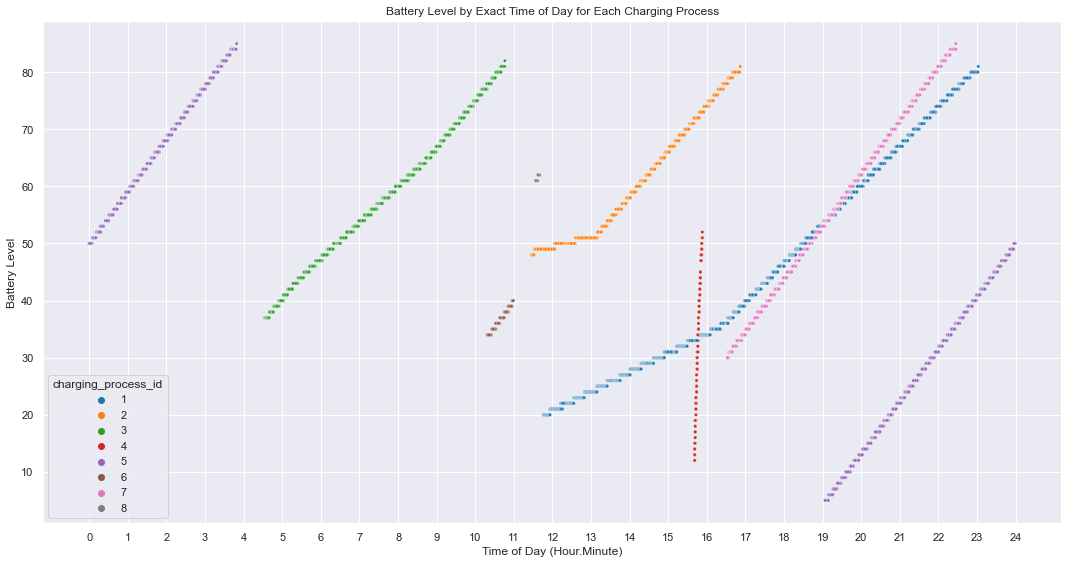

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path = 'teslamate_data.xlsx'  # 여기를 실제 파일 경로로 변경하세요

# Read the 'charges' sheet
charges_df = pd.read_excel(file_path, sheet_name='charges')

# Convert 'date' column to datetime
charges_df['date'] = pd.to_datetime(charges_df['date'])

# Extract hours and minutes as a single numeric value
charges_df['hour_minute'] = charges_df['date'].dt.hour + charges_df['date'].dt.minute / 60

# Set the plot style
sns.set(style="darkgrid")

# Create a scatter plot
plt.figure(figsize=(15, 8))
sns.scatterplot(x='hour_minute', y='battery_level', hue='charging_process_id', data=charges_df, palette='tab10', s=10)

# Adding plot title and labels
plt.title('Battery Level by Exact Time of Day for Each Charging Process')
plt.xlabel('Time of Day (Hour.Minute)')
plt.ylabel('Battery Level')
plt.xticks(range(0, 25))  # setting x-ticks to represent each hour of the day
plt.tight_layout()

# Display the plot
plt.show()


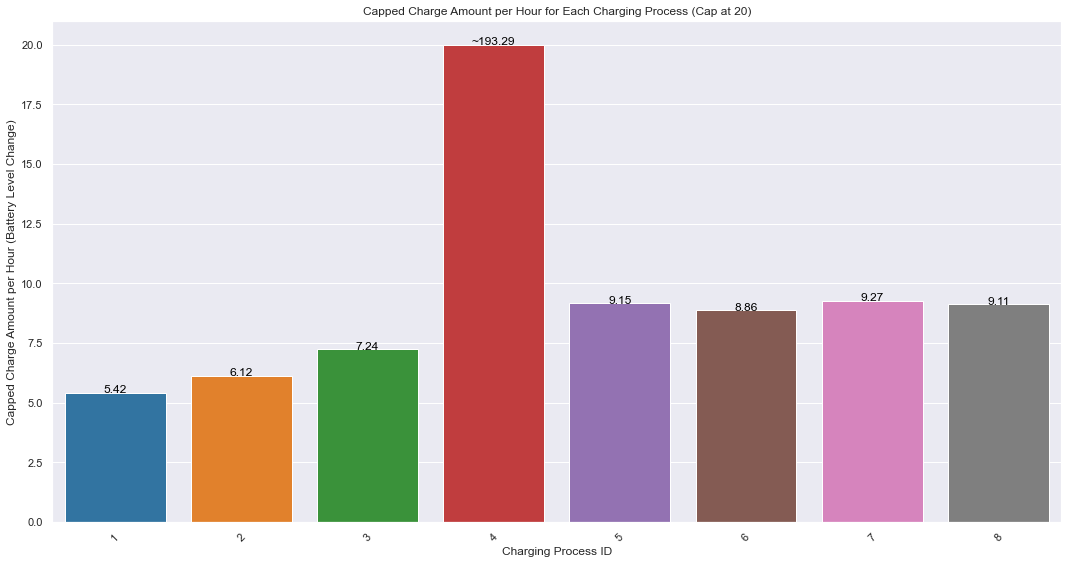

In [4]:
# Read the 'charges' sheet
charges_df = pd.read_excel(file_path, sheet_name='charges')

# Convert 'date' column to datetime
charges_df['date'] = pd.to_datetime(charges_df['date'])

# Calculating the charge amount per hour for each charging process
charge_amount_per_hour = charges_df.groupby('charging_process_id').apply(
    lambda x: (x['battery_level'].max() - x['battery_level'].min()) / ((x['date'].max() - x['date'].min()).seconds / 3600)
).reset_index(name='charge_amount_per_hour')

# Setting a specific cap value of 20 for the bar chart
cap_value = 20  # Cap value set to 20

# Capping the values at the cap_value
charge_amount_per_hour['capped_charge_amount'] = charge_amount_per_hour['charge_amount_per_hour'].apply(lambda x: cap_value if x > cap_value else x)
charge_amount_per_hour['is_capped'] = charge_amount_per_hour['charge_amount_per_hour'].apply(lambda x: x > cap_value)

# Creating a bar chart with capped values
plt.figure(figsize=(15, 8))
bar_plot = sns.barplot(x='charging_process_id', y='capped_charge_amount', data=charge_amount_per_hour, palette='tab10')

# Adding a tilde symbol (~) on capped bars and actual values on top of the bars
for idx, row in charge_amount_per_hour.iterrows():
    if row['is_capped']:
        bar_plot.text(idx, row['capped_charge_amount'], f'~{row["charge_amount_per_hour"]:.2f}', color='black', ha="center")
    else:
        bar_plot.text(idx, row['capped_charge_amount'], f'{row["charge_amount_per_hour"]:.2f}', color='black', ha="center")

# Adding plot title and labels
plt.title('Capped Charge Amount per Hour for Each Charging Process (Cap at 20)')
plt.xlabel('Charging Process ID')
plt.ylabel('Capped Charge Amount per Hour (Battery Level Change)')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


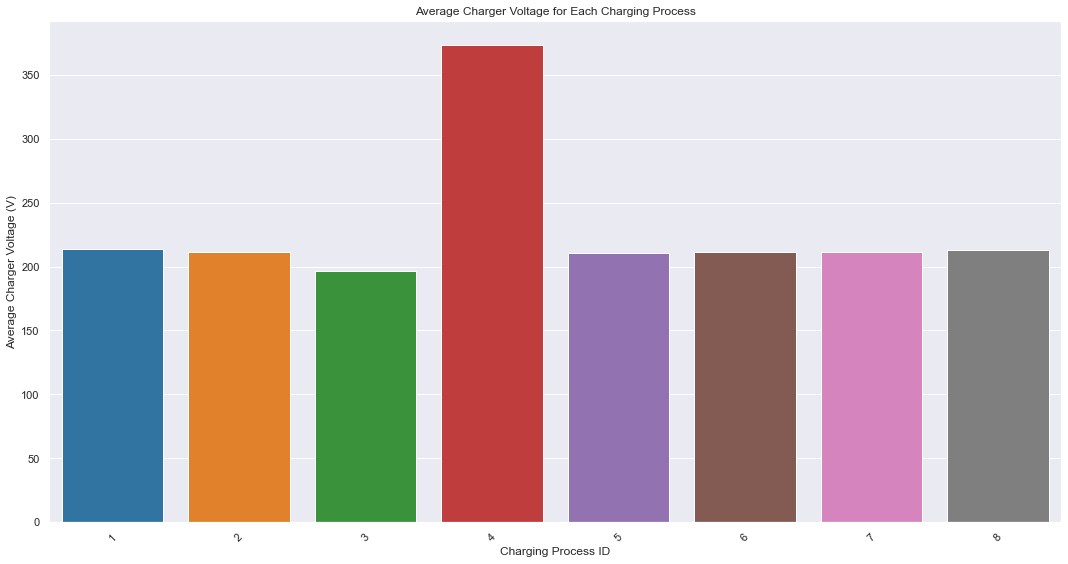

In [5]:
# Calculating average charger voltage for each charging process
average_voltage_per_process = charges_df.groupby('charging_process_id')['charger_voltage'].mean()

# Creating a dataframe for the bar chart
voltage_df = pd.DataFrame({
    'charging_process_id': average_voltage_per_process.index,
    'average_voltage': average_voltage_per_process.values
})

# Creating a bar chart for average charger voltage per charging process
plt.figure(figsize=(15, 8))
bar_plot = sns.barplot(x='charging_process_id', y='average_voltage', data=voltage_df, palette='tab10')

# Adding plot title and labels
plt.title('Average Charger Voltage for Each Charging Process')
plt.xlabel('Charging Process ID')
plt.ylabel('Average Charger Voltage (V)')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


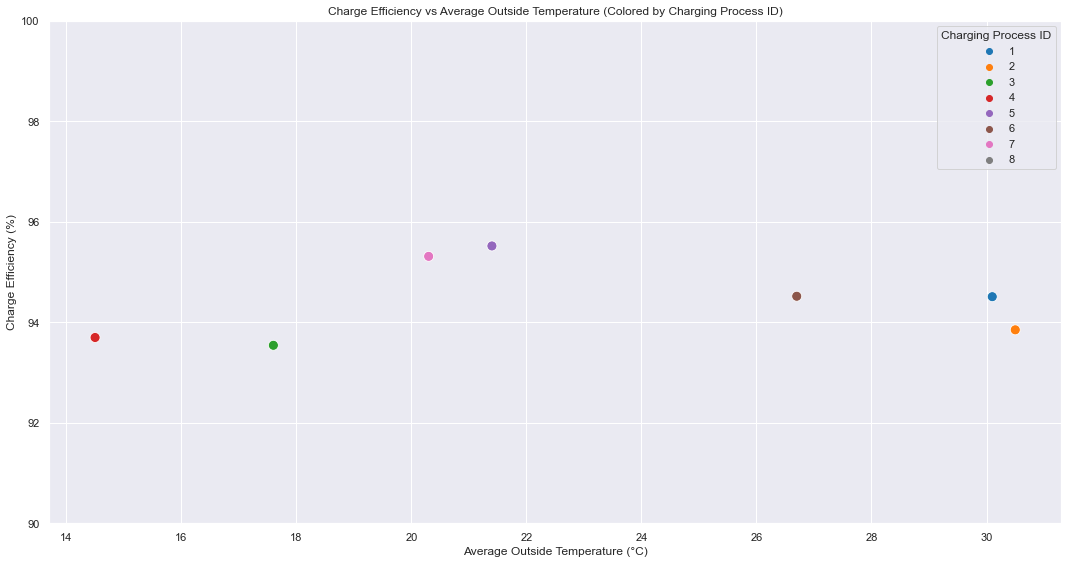

In [6]:

# 'charging_processes' 시트 로드
charging_processes_df = pd.read_excel(file_path, sheet_name='charging_processes')

# 'charging_process_id'에 따른 색상 팔레트 생성
palette = sns.color_palette("tab10", charges_df['charging_process_id'].nunique())

# charge_energy_added와 charge_energy_used 컬럼을 숫자로 변환
charging_processes_df['charge_energy_added'] = pd.to_numeric(charging_processes_df['charge_energy_added'], errors='coerce')
charging_processes_df['charge_energy_used'] = pd.to_numeric(charging_processes_df['charge_energy_used'], errors='coerce')

# 충전 효율성 계산 (추가된 에너지 / 사용된 에너지 * 100)
charging_processes_df['charge_efficiency'] = (charging_processes_df['charge_energy_added'] / charging_processes_df['charge_energy_used']) * 100

# 평균 외부 온도를 숫자로 변환
charging_processes_df['outside_temp_avg'] = pd.to_numeric(charging_processes_df['outside_temp_avg'], errors='coerce')

# 'charging_processes' 데이터프레임에 'charging_process_id' 컬럼 추가
charging_processes_df['charging_process_id'] = charging_processes_df['id']

# 충전 효율성을 평균 외부 온도에 따라 시각화 (Y축 범위 조정)
plt.figure(figsize=(15, 8))
scatter_plot = sns.scatterplot(x='outside_temp_avg', y='charge_efficiency', hue='charging_process_id', 
                               data=charging_processes_df, palette=palette, s=100, marker='o')

# 차트 제목 및 라벨 설정
plt.title('Charge Efficiency vs Average Outside Temperature (Colored by Charging Process ID)')
plt.xlabel('Average Outside Temperature (°C)')
plt.ylabel('Charge Efficiency (%)')
plt.ylim(90, 100)  # Y축 범위 설정
plt.legend(title='Charging Process ID')
plt.tight_layout()

# 차트 표시
plt.show()


### Drive Data Analysis

In [15]:
# 1. 데이터 불러오기
drives_df = pd.read_excel('teslamate_data.xlsx', sheet_name='drives')

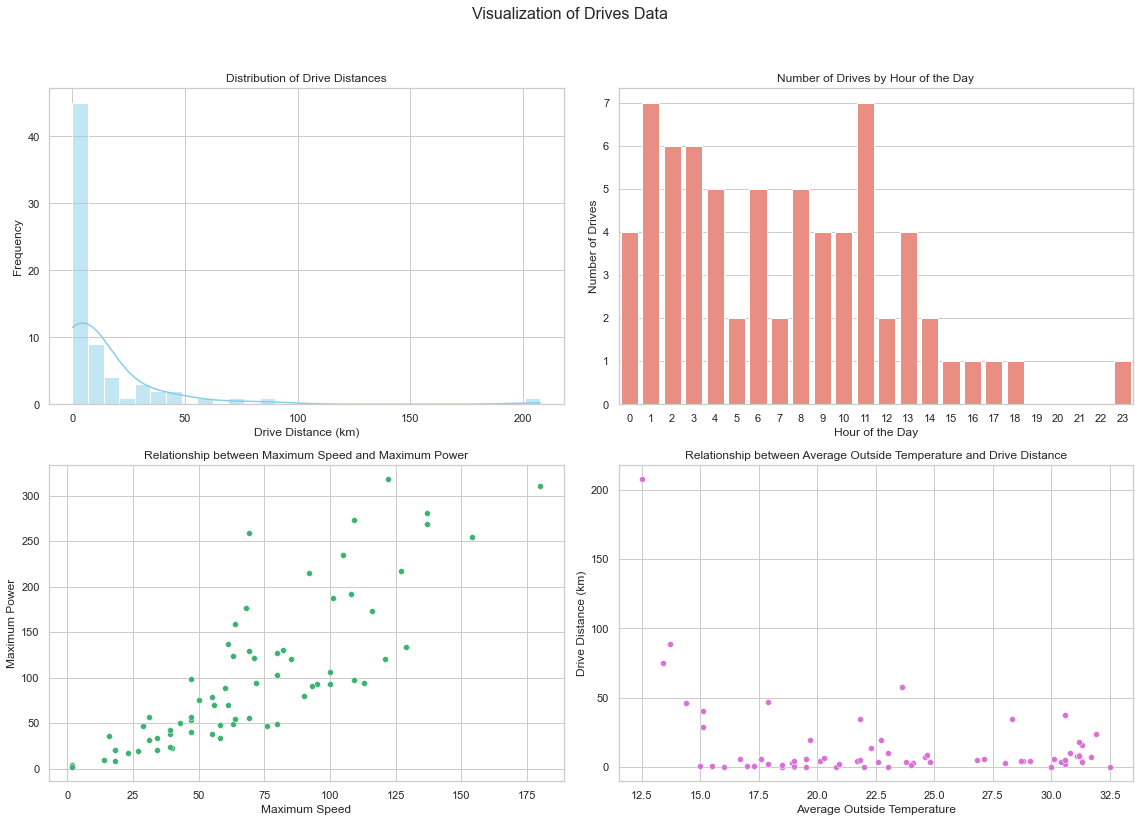

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 주행 거리 계산
drives_df['drive_distance'] = drives_df['end_km'] - drives_df['start_km']

# 시간대별 주행 계산
drives_df['start_hour'] = drives_df['start_date'].apply(lambda x: pd.to_datetime(x).hour)

# 시간대별 주행 횟수 집계
hourly_drives_count = drives_df['start_hour'].value_counts().sort_index()
# 모든 시간대(0-23)에 대한 데이터가 있는지 확인하고 없으면 0으로 채움
hourly_drives_count = hourly_drives_count.reindex(range(24), fill_value=0)

# Plot settings
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Visualization of Drives Data", fontsize=16)

# 1. 주행 거리 분포
sns.histplot(drives_df['drive_distance'], ax=axes[0, 0], kde=True, color='skyblue', bins=30)
axes[0, 0].set_title('Distribution of Drive Distances')
axes[0, 0].set_xlabel('Drive Distance (km)')
axes[0, 0].set_ylabel('Frequency')

# 2. 시간대별 주행 (수정)
sns.barplot(x=hourly_drives_count.index, y=hourly_drives_count.values, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Number of Drives by Hour of the Day')
axes[0, 1].set_xlabel('Hour of the Day')
axes[0, 1].set_ylabel('Number of Drives')

# 3. 속도 및 출력 관계
sns.scatterplot(data=drives_df, x='speed_max', y='power_max', ax=axes[1, 0], color='mediumseagreen')
axes[1, 0].set_title('Relationship between Maximum Speed and Maximum Power')
axes[1, 0].set_xlabel('Maximum Speed')
axes[1, 0].set_ylabel('Maximum Power')

# 4. 온도와 주행 거리 관계
sns.scatterplot(data=drives_df, x='outside_temp_avg', y='drive_distance', ax=axes[1, 1], color='orchid')
axes[1, 1].set_title('Relationship between Average Outside Temperature and Drive Distance')
axes[1, 1].set_xlabel('Average Outside Temperature')
axes[1, 1].set_ylabel('Drive Distance (km)')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


C:\Users\kwon9\AppData\Roaming\Python\Python39\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step


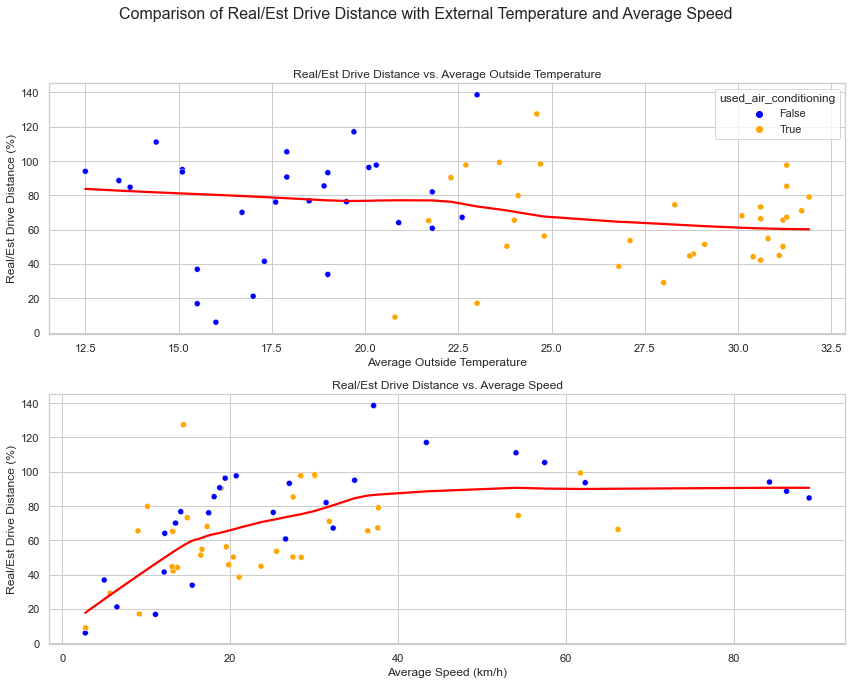

In [9]:
# 이상적인 주행거리 대비 실제 주행거리 비율 컬럼 생성
drives_df['drive_ratio'] = drives_df['drive_distance'] / (drives_df['start_ideal_range_km'] - drives_df['end_ideal_range_km'])

# 주행거리와 주행시간을 사용하여 평균속도 컬럼 생성
drives_df['avg_speed'] = drives_df['drive_distance'] / (drives_df['duration_min'] / 60)  # km/h

# drive ratio 값을 % 형태로 변경
drives_df['drive_ratio'] = drives_df['drive_ratio'] * 100

# air conditioning 컬럼 추가
drives_df['used_air_conditioning'] = (drives_df['inside_temp_avg'] < drives_df['outside_temp_avg'])


fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle("Comparison of Real/Est Drive Distance with External Temperature and Average Speed", fontsize=16)

# 외부온도와 Real/Est Drive Distance 비교 with LOESS trendline
sns.regplot(data=drives_df, x='outside_temp_avg', y='drive_ratio', ax=axes[0], color='dodgerblue', scatter_kws={'s': 10}, line_kws={"color": "red"}, lowess=True)
# Scatter plot with different colors for True (blue) and False (orange) on the first plot
sns.scatterplot(data=drives_df, x='outside_temp_avg', y='drive_ratio', hue='used_air_conditioning', palette=['blue', 'orange'], ax=axes[0])
axes[0].set_title('Real/Est Drive Distance vs. Average Outside Temperature')
axes[0].set_xlabel('Average Outside Temperature')
axes[0].set_ylabel('Real/Est Drive Distance (%)')

# 평균속도와 Real/Est Drive Distance 비교 with LOESS trendline
sns.regplot(data=drives_df, x='avg_speed', y='drive_ratio', ax=axes[1], color='darkorange', scatter_kws={'s': 10}, line_kws={"color": "red"}, lowess=True)
# Scatter plot with different colors for True (blue) and False (orange) on the second plot, but hide the legend
sns.scatterplot(data=drives_df, x='avg_speed', y='drive_ratio', hue='used_air_conditioning', palette=['blue', 'orange'], ax=axes[1], legend=False)
axes[1].set_title('Real/Est Drive Distance vs. Average Speed')
axes[1].set_xlabel('Average Speed (km/h)')
axes[1].set_ylabel('Real/Est Drive Distance (%)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Position (Drive 경로 시각화)

In [10]:
print("-----------------------------------\n[Route Visualizator v1.0 by teon-u]\n-----------------------------------")
### LOADING LIBRARY ###
print("Lodading library . ",end="")
import folium
from folium import IFrame
import base64
import pandas as pd
print(". ",end="")
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
print(". ",end="")
import matplotlib.colors as mcolors
import math
from tqdm import tqdm
from IPython.display import display
import time

print("done")
### Data Load & Preprocess ###
# 1. 데이터 불러오기
print("Load & Preprocess data . ",end="")
positions_df = pd.read_excel('teslamate_data.xlsx', sheet_name='positions')
# 2. 데이터 전처리: "\N" 값을 NaN으로 변경
print(". ",end="")
positions_df.replace(r"\N", np.nan, inplace=True)
positions_df.replace(r"\\N", np.nan, inplace=True)
# 3. 'date' 컬럼을 datetime 타입으로 변환
print(". ",end="")
positions_df['date'] = pd.to_datetime(positions_df['date'])
# 4. 각 컬럼의 데이터 타입 최적화
print(". ",end="")
cols_to_float = ['speed', 'ideal_battery_range_km', 'outside_temp', 'fan_status', 'driver_temp_setting',
                 'passenger_temp_setting', 'drive_id', 'inside_temp', 'est_battery_range_km', 
                 'rated_battery_range_km', 'usable_battery_level', 'tpms_pressure_fl', 
                 'tpms_pressure_fr', 'tpms_pressure_rl', 'tpms_pressure_rr']
bool_map = {'t': True, 'f': False}
cols_to_bool = ['is_climate_on', 'is_rear_defroster_on', 'is_front_defroster_on', 'battery_heater', 'battery_heater_on']

for col in cols_to_float:
    positions_df[col] = pd.to_numeric(positions_df[col], errors='coerce')
for col in cols_to_bool:
    positions_df[col] = positions_df[col].map(bool_map).astype('boolean')

print(". ",end="")
positions_df.drop(['battery_heater_no_power', 'car_id'], axis=1, inplace=True)
positions_df['drive_id'] = positions_df['drive_id'].fillna(method='ffill').fillna(method='bfill')
positions_df_sorted = positions_df.sort_values(by='date').reset_index(drop=True)
# 5. 'elevation' 컬럼의 결측치 처리
print(". ",end="")
elevation_null = positions_df_sorted['elevation'].isnull()
groups = ((elevation_null != elevation_null.shift()).cumsum())
groups_counts = elevation_null.groupby(groups).cumsum()
continuous_null_ranges = groups_counts[elevation_null].groupby(groups).agg(['idxmin', 'idxmax', 'count']).reset_index(drop=True)
continuous_null_ranges.columns = ['Start Index', 'End Index', 'Count']
for index, row in continuous_null_ranges.iterrows():
    start_idx = row['Start Index']
    end_idx = row['End Index']
    if start_idx > 0:
        prev_val = positions_df_sorted.loc[start_idx - 1, 'elevation']
    else:
        prev_val = np.nan
    if end_idx < len(positions_df_sorted) - 1:
        next_val = positions_df_sorted.loc[end_idx + 1, 'elevation']
    else:
        next_val = np.nan
    prev_val = float(prev_val) if pd.notnull(prev_val) else np.nan
    next_val = float(next_val) if pd.notnull(next_val) else np.nan
    mean_val = (prev_val + next_val) / 2
    positions_df_sorted.loc[start_idx:end_idx, 'elevation'] = mean_val

# 6. 'speed' 컬럼의 결측치 처리
print(". ",end="")
positions_df_sorted['speed'].fillna(0, inplace=True)

# 7. 수치형 데이터 컬럼의 결측치 처리
print(". ",end="")
numerical_cols = positions_df_sorted.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    positions_df_sorted[col] = positions_df_sorted[col].interpolate(method='linear', limit_direction='both')

# 8. 불리언 데이터 컬럼의 결측치 처리
print(". ",end="")
boolean_cols = positions_df_sorted.select_dtypes(include=['boolean']).columns
for col in boolean_cols:
    positions_df_sorted[col].fillna(method='ffill', inplace=True)

# 9. 'elevation' 컬럼의 남아있는 결측치 처리
print(". ",end="")
positions_df_sorted['elevation'].fillna(method='ffill', inplace=True)
positions_df_sorted['elevation'].fillna(method='bfill', inplace=True)
print("done")


### SETUP COLORS ###
print("Setup Colors & Functions . ",end="")
# Define a more vivid colormap
vivid_cmap = plt.get_cmap('jet')

# Get the minimum and maximum speed values for normalization
print(". ",end="")
min_speed = 0
max_speed = 100 #positions_df_sorted['speed'].max()



### SETUP FUCNTIONS ###
# Function to map speed values to colors
print(". ",end="")
def speed_to_color(speed, cmap):
    norm_speed = (speed - min_speed) / (max_speed - min_speed)  # Normalize speed between 0 and 1
    rgba_color = cmap(norm_speed)  # Get the corresponding color from the colormap
    hex_color = mcolors.rgb2hex(rgba_color)  # Convert RGBA to hex
    return hex_color


### SETUP ZOOM LEVEL
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

def calculate_zoom_start(lat1, lon1, lat2, lon2):
    distance = haversine(lat1, lon1, lat2, lon2)
    if distance < 1:  
        return 13
    elif distance < 5:
        return 12
    elif distance < 10:
        return 11
    elif distance < 20:
        return 10
    elif distance < 50:
        return 9
    elif distance < 100:
        return 8
    elif distance < 200:
        return 7
    elif distance < 500:
        return 6
    else:
        return 5  # Default for very long distances
print("done")

-----------------------------------
[Route Visualizator v1.0 by teon-u]
-----------------------------------
Lodading library . . . done
Load & Preprocess data . . . . . . . . . . done
Setup Colors & Functions . . . done


In [11]:
#Automatic code 1
#counter = 0

while True:
    print("------------------------------\n[Route Visualization Sequence]\n------------------------------")
    #Automatic code 2
    #counter += 1

    try:
        # Set drive_id (Manual)
        demo_drive_id = int(input("Request drive number to visualize route :"))
        
        # Automatic code 3
        #demo_drive_id = counter

        print("Recieved drive id :[",demo_drive_id,"]")
        if demo_drive_id == 0:
            print("Visualization sequence ended")
            break

        # Automatic code 4 (end)
        #elif demo_drive_id > max(positions_df_sorted["drive_id"]):
        #    break

        print("[1] Filtering data by", demo_drive_id," . . .",end="")
        # Filter the data for the selected drive_id
        drive_data_demo = positions_df_sorted[positions_df_sorted['drive_id'] == demo_drive_id].copy()
        print("done")
        # Replacing Nan value to 0
        print("[2] Replace Null value as Zero . . .",end="")
        drive_data_demo['speed'] = drive_data_demo['speed'].replace('\\N', 0).astype(float)
        print("done")

        # SETUP ZOOM LEVEL
        print("[3] Setup Zoom level . . .",end="")
        start_lat, start_lon = drive_data_demo.iloc[0][['latitude', 'longitude']]
        end_lat, end_lon = drive_data_demo.iloc[-1][['latitude', 'longitude']]
        print("done")

    except:
        print("\nERR : Input id might be wrong. Rollback to input sequence.")
        continue



    ### SETUP ZOOM POINT
    print("[4] Setup ZOOM IN point . . .",end="")
    # Divide the dataframe into segments and calculate the average latitude and longitude for each segment
    segment_size = 10  # Define the size of each segment
    num_segments = -(-len(drive_data_demo) // segment_size)  # Calculate the number of segments

    avg_latitudes = []
    avg_longitudes = []

    # Iterate over each segment and calculate the average latitude and longitude
    for i in range(num_segments):
        start_idx = i * segment_size
        end_idx = start_idx + segment_size
        segment = drive_data_demo.iloc[start_idx:end_idx]
        
        avg_latitudes.append(segment['latitude'].mean())
        avg_longitudes.append(segment['longitude'].mean())

    # Calculate the overall average latitude and longitude
    avg_latitude = np.mean(avg_latitudes)
    avg_longitude = np.mean(avg_longitudes)

    ### SETUP VISUALIZATION
    # Reinitialize the final thicker vivid map at the first position with a zoom level
    print("[5] Setup visualization . . .",end="")
    m_final_thicker_vivid_drive_demo = folium.Map(
            location=[avg_latitude,avg_longitude], 
            zoom_start=calculate_zoom_start(start_lat, start_lon, end_lat, end_lon)+2,
            tiles='CartoDB Positron',
            width='100',
            height='80')
    print("done")

    # Reiterate over the rows and add a vivid colored line segment with double weight for each pair of consecutive points
    print("[6] Converting point to route")
    for i in tqdm(range(1, drive_data_demo.shape[0]), desc="Processing", unit="segment"):
        start_point = drive_data_demo.iloc[i - 1][['latitude', 'longitude']].values.tolist()
        end_point = drive_data_demo.iloc[i][['latitude', 'longitude']].values.tolist()
        speed = drive_data_demo.iloc[i]['speed']
        
        # Get the color corresponding to the speed value using the vivid colormap
        color = speed_to_color(speed, vivid_cmap) if not np.isnan(speed) else 'gray'
        
        # Add the colored line segment to the map with double weight
        folium.PolyLine([start_point, end_point], color=color, weight=6, opacity=1.0).add_to(m_final_thicker_vivid_drive_demo)
    ###


    ### SETUP START/END POINT
    print("[7] Setup start/end point . . .",end="")
    # Add a green circle marker for the start point
    folium.CircleMarker(
        location=drive_data_demo.iloc[0][['latitude', 'longitude']].values.tolist(),
        radius=7,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.8
    ).add_to(m_final_thicker_vivid_drive_demo)

    # Add a red circle marker for the end point
    folium.CircleMarker(
        location=drive_data_demo.iloc[-1][['latitude', 'longitude']].values.tolist(),
        radius=7,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.8
    ).add_to(m_final_thicker_vivid_drive_demo)
    print("done")
    ###


    ### SETUP TITLE TEXT
    # Reconstruct the title string
    print("[8] Setup title texting . . .",end="")
    title_str = f"Drive route {demo_drive_id}"

    # Create an HTML string
    html = f"""
        <h3 style="font-size:26px; font-family:Arial; margin-bottom:0px;">
            {title_str}
        </h3>
    """

    # Create an IFrame and add it to the map as an Html child
    iframe = IFrame(html=html, width=300, height=46)
    title = folium.Element()
    title.add_child(iframe)
    m_final_thicker_vivid_drive_demo.get_root().html.add_child(title)
    print("done")

    # Show the final map with the title
    print("[9] Visualize drive route", demo_drive_id)
    display(m_final_thicker_vivid_drive_demo)

    # Next & Return Sequence
    time.sleep(5)
    print("Visualization sequence done. \nSet drive id 0 to exit")

------------------------------
[Route Visualization Sequence]
------------------------------
Recieved drive id :[ 1 ]
[1] Filtering data by 1  . . .done
[2] Replace Null value as Zero . . .done
[3] Setup Zoom level . . .done
[4] Setup ZOOM IN point . . .[5] Setup visualization . . .done
[6] Converting point to route


Processing: 100%|██████████| 3643/3643 [00:05<00:00, 700.20segment/s]


[7] Setup start/end point . . .done
[8] Setup title texting . . .done
[9] Visualize drive route 1


Visualization sequence done. 
Set drive id 0 to exit
------------------------------
[Route Visualization Sequence]
------------------------------
Recieved drive id :[ 0 ]
Visualization sequence ended


### 추가 시각화

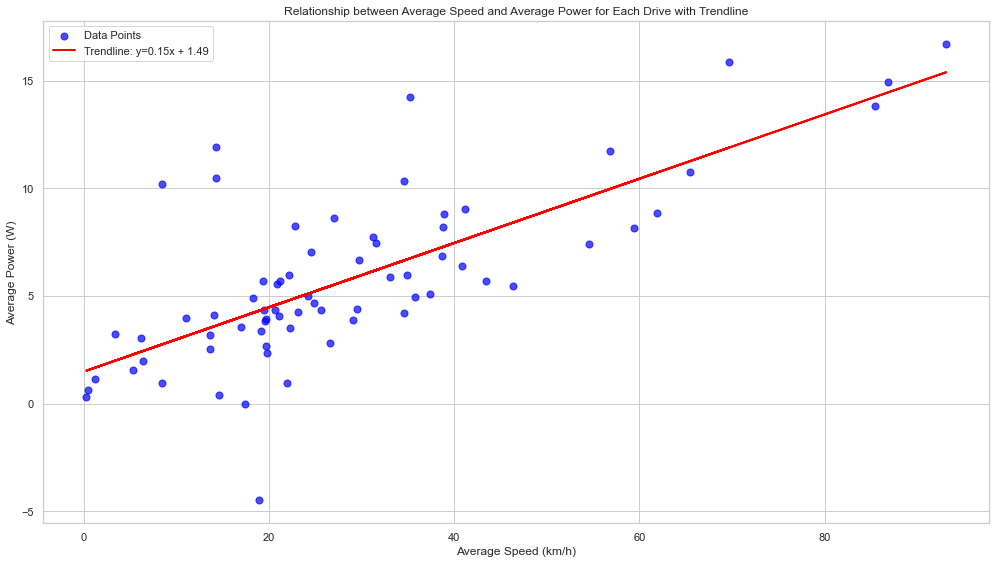

In [17]:
# Scatter plot of average speed vs. average power for each 'drive_id' with a trendline

# Grouping by 'drive_id' and calculating mean for 'speed' and 'power'
clustered_data = positions_df_sorted.groupby('drive_id')[['speed', 'power']].mean().reset_index()

plt.figure(figsize=(14, 8))
plt.scatter(clustered_data['speed'], clustered_data['power'], alpha=0.7, s=50, c='blue', label='Data Points')
m, b = np.polyfit(clustered_data['speed'], clustered_data['power'], 1)  # Linear regression
plt.plot(clustered_data['speed'], m*clustered_data['speed'] + b, color='red', linewidth=2, label=f'Trendline: y={m:.2f}x + {b:.2f}')
plt.xlabel('Average Speed (km/h)')
plt.ylabel('Average Power (W)')
plt.title('Relationship between Average Speed and Average Power for Each Drive with Trendline')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


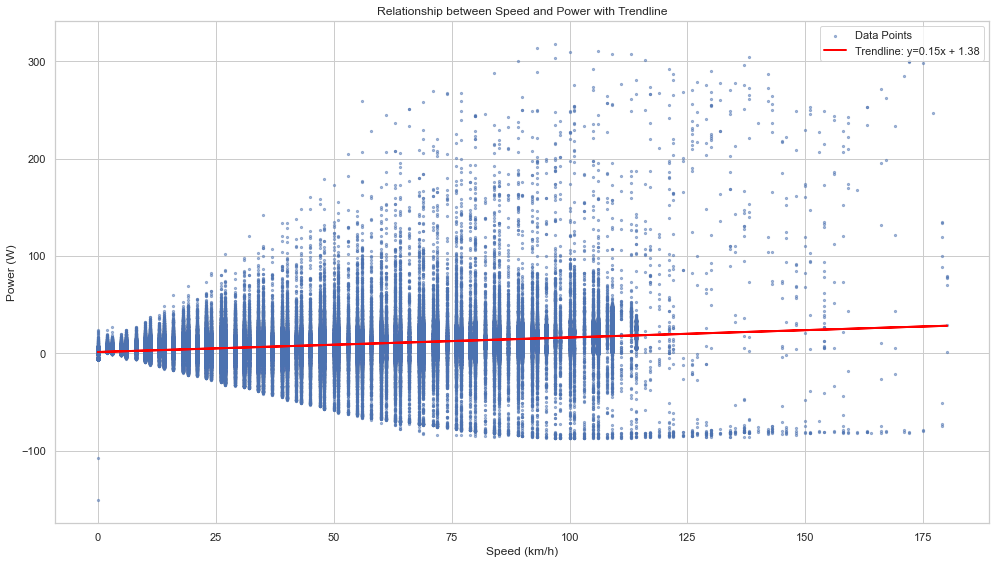

In [14]:
# Scatter plot of speed vs. power with a trendline
plt.figure(figsize=(14, 8))
plt.scatter(positions_df_sorted['speed'], positions_df_sorted['power'], alpha=0.5, s=5, label='Data Points')
m, b = np.polyfit(positions_df_sorted['speed'], positions_df_sorted['power'], 1)  # Linear regression
plt.plot(positions_df_sorted['speed'], m*positions_df_sorted['speed'] + b, color='red', linewidth=2, label=f'Trendline: y={m:.2f}x + {b:.2f}')
plt.xlabel('Speed (km/h)')
plt.ylabel('Power (W)')
plt.title('Relationship between Speed and Power with Trendline')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

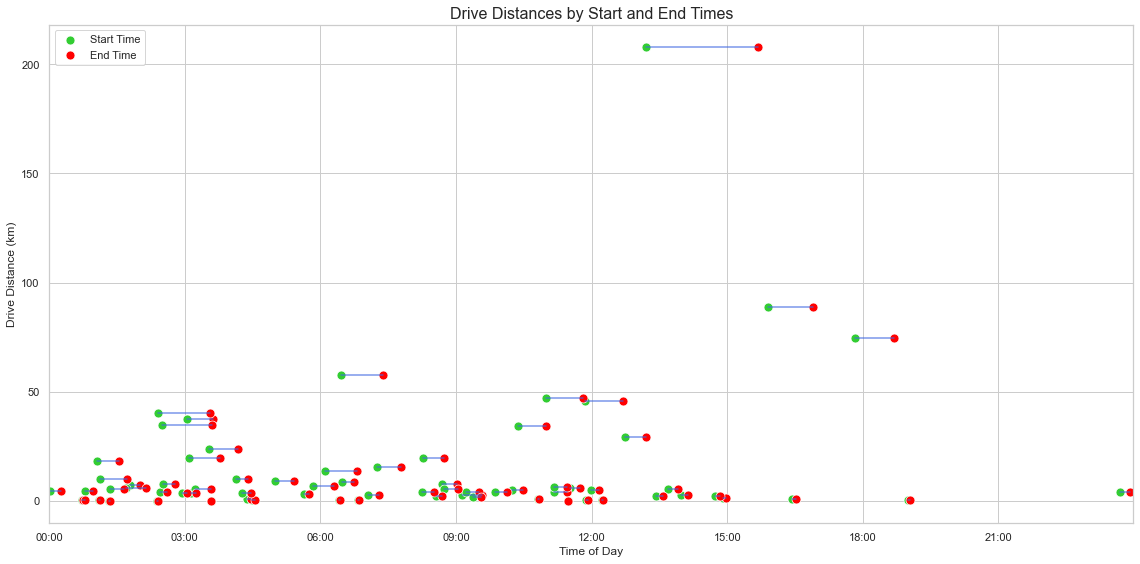

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas as pd


# start_date와 end_date에서 시간만 추출
drives_df['start_hour'] = pd.to_datetime(drives_df['start_date']).dt.time
drives_df['end_hour'] = pd.to_datetime(drives_df['end_date']).dt.time

# 시각화
fig, ax = plt.subplots(figsize=(16, 8))

# 각 주행에 대한 출발시간과 도착시간을 X축에 표시, 이동거리를 Y축에 표시
for _, row in drives_df.iterrows():
    start_hour = matplotlib.dates.date2num(datetime.datetime.combine(datetime.date.today(), row['start_hour']))
    end_hour = matplotlib.dates.date2num(datetime.datetime.combine(datetime.date.today(), row['end_hour']))
    ax.plot([start_hour, end_hour], [row['distance'], row['distance']], color='royalblue', alpha=0.7)

# 출발시간을 점으로 표시
sns.scatterplot(x=drives_df['start_hour'].apply(lambda x: matplotlib.dates.date2num(datetime.datetime.combine(datetime.date.today(), x))), 
                y=drives_df['distance'], ax=ax, color='limegreen', s=80, label='Start Time')

# 도착시간을 점으로 표시
sns.scatterplot(x=drives_df['end_hour'].apply(lambda x: matplotlib.dates.date2num(datetime.datetime.combine(datetime.date.today(), x))), 
                y=drives_df['distance'], ax=ax, color='red', s=80, label='End Time')

ax.set_title('Drive Distances by Start and End Times', fontsize=16)
ax.set_xlabel('Time of Day')
ax.set_ylabel('Drive Distance (km)')
ax.legend(loc='upper left')
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
ax.set_xlim(matplotlib.dates.date2num(datetime.datetime.combine(datetime.date.today(), datetime.time(0, 0))),
            matplotlib.dates.date2num(datetime.datetime.combine(datetime.date.today(), datetime.time(23, 59))))
ax.set_xticks([matplotlib.dates.date2num(datetime.datetime.combine(datetime.date.today(), datetime.time(i, 0))) for i in range(0, 24, 3)])

plt.tight_layout()
plt.show()


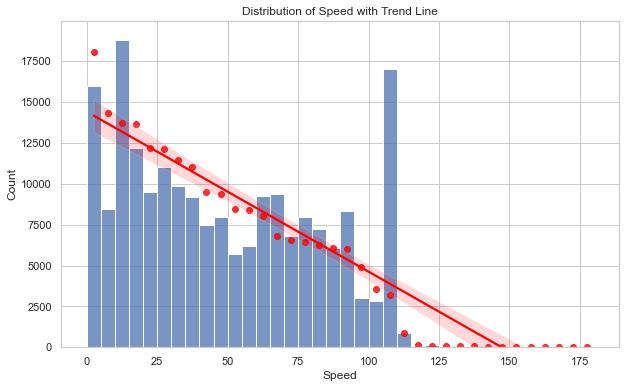

In [28]:

# Defining the bin edges (0, 5, 10, ..., up to the maximum speed rounded up to the nearest multiple of 5)
max_speed = positions_df_sorted['speed'].max()
bin_edges = np.arange(0, max_speed + 5, 5)

# Calculating the mean speed for each bin
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
speed_counts = positions_df_sorted['speed'].value_counts(bins=bin_edges)
mean_speed_per_bin = [positions_df_sorted['speed'][positions_df_sorted['speed'].between(left, right)].mean() for left, right in zip(bin_edges[:-1], bin_edges[1:])]



# Plotting the distribution of the 'speed' column
plt.figure(figsize=(10, 6))
sns.histplot(positions_df_sorted['speed'], bins=bin_edges, kde=False)

# Adding a trend line using the mean speeds
sns.regplot(x=bin_centers, y=speed_counts.values, scatter=True, color='red')

plt.title('Distribution of Speed with Trend Line')
plt.xlabel('Speed')
plt.ylabel('Count')

# Adjusting Y-axis to not show values below 0
plt.ylim(bottom=0)


# Show the plot
plt.show()
